### Importa librerie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text
from custom.watermarks import add_watermark

### Definizione funzioni

In [2]:
def get_vaccine_data(country, time_window=30, fully=False):
    """ Recupera dati sulla frazione di vaccinati medi negli ultimi 30 giorni"""
    df_vacc_country = df_global[df_global["location"] == country]
    if fully==False:
        vacc_fully = np.array(df_vacc_country["people_vaccinated_per_hundred"][-(time_window+1):-1])
    else:
        vacc_fully = np.array(df_vacc_country["people_fully_vaccinated_per_hundred"][-(time_window+1):-1])
    vacc_ultimi_Ngiorni = np.average(vacc_fully[~np.isnan(vacc_fully)])
    return vacc_ultimi_Ngiorni

def get_deaths(country, time_window=30):
    """ Recupera dati sul numero assoluto di decessi negli ultimi 30 giorni"""
    decessi = np.array(df_global[df_global["location"] == country]['total_deaths'])
    decessi_ultimi_Ngiorni = decessi[-1] - decessi[-(time_window+1)]
    return decessi_ultimi_Ngiorni

def get_value_from_df(countries, column, scale_factor=1):
    """ Recupera l'ultimo valore della column specificata, per la lista di countries.
        Se Specificato, dividi per scale_factor.
    """
    values = []
    for el in countries:
         values.append(df_global[df_global["location"] == el][column].tolist()[-1]*scale_factor)
    return values

def remove_nan_two_lists(list_source, list_target):
    """ Rimuove dalla lista_target gli elementi che nella lista_source sono nan. Le due liste possono coincidere"""
    for i, el in enumerate(list_source):
        if str(el) == 'nan':
            list_target.pop(i)
    return list_target

In [3]:
# def get_population(countries):
#     """ Recupera dati sulla popolazione dei paesi specificati, espressi in milione di abitanti (input = lista)"""
#     abitanti = {key: '' for key in countries}
#     for el in countries:
#         abitanti[el] = df_global[df_global["location"] == el]['population'].tolist()[-1]/1e6
#     return abitanti

# def get_gdp(countries):
#     """ Recupera dati sullo human_development_index dei paesi specificati (input = lista)"""
#     gdp = {key: '' for key in countries}
#     for el in countries:
#         gdp[el] = df_global[df_global["location"] == el]['gdp_per_capita'].tolist()[-1]
#     return gdp

# def get_life_expectancy(countries):
#     """ Recupera dati sullo human_development_index dei paesi specificati (input = lista)"""
#     life_expectancy = {key: '' for key in countries}
#     for el in countries:
#         life_expectancy[el] = df_global[df_global["location"] == el]['life_expectancy'].tolist()[-1]
#     return life_expectancy

### Importa dati da Our World in Data

In [4]:
file_owid = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df_global = pd.read_csv(file_owid)

In [5]:
#DEBUGONLY
# df_global[df_global['location']=='Italy'].tail()
# df_global.columns
# df_global['location'].unique()

In [6]:
# Dataframe solo per paesi europei
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 
                'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 
                'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
df_europe = df_global.loc[df_global['location'].isin(eu_countries)]

In [7]:
#DEBUGONLY
# df_europe[df_europe['location']=='Luxembourg'].tail(30)['people_vaccinated_per_hundred'].tolist()

### Calcoli con diversi Paesi

In [8]:
# Definizione paesi e relative label
paesi = eu_countries
paesi_label = ['Austria', 'Belgio', 'Bulgaria', 'Croazia', 'Cipro', 'Repubblica Ceca', 'Danimarca', 'Estonia', 'Finlandia', 
                'Francia', 'Germania', 'Grecia', 'Ungheria', 'Irlanda', 'Italia', 'Lettonia', 'Lituania', 'Lussemburgo', 
                'Malta', 'Paesi Bassi', 'Polonia', 'Portogallo', 'Romania', 'Slovacchia', 'Slovenia', 'Spagna', 'Svezia']

In [9]:
# Calcola vaccinati e decessi
abitanti = get_value_from_df(paesi, 'population', scale_factor=1e-6)

dec_res=[] # Decessi per milione di abitanti ultimi tw giorni
vacc_res=[] # % vaccinati media ultimi tw giorni

tw = 30

for i, p in enumerate(paesi):
    vacc_res.append(get_vaccine_data(p, time_window = tw, fully=False))
    dec_res.append(get_deaths(p, time_window = tw)/abitanti[i])

In [10]:
# Dati potenzialmente interessanti
'''['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index',
       'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative',
       'excess_mortality', 'excess_mortality_cumulative_per_million']'''

"['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',\n       'new_cases_smoothed', 'total_deaths', 'new_deaths',\n       'new_deaths_smoothed', 'total_cases_per_million',\n       'new_cases_per_million', 'new_cases_smoothed_per_million',\n       'total_deaths_per_million', 'new_deaths_per_million',\n       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',\n       'icu_patients_per_million', 'hosp_patients',\n       'hosp_patients_per_million', 'weekly_icu_admissions',\n       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',\n       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',\n       'total_tests_per_thousand', 'new_tests_per_thousand',\n       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',\n       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',\n       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',\n       'new_vaccinations', 'new_vaccinations_smoothed',\

In [11]:
# Ricava altre grandezze
gdp = get_value_from_df(paesi, 'gdp_per_capita')
# stringency_index = get_value_from_df(paesi, 'stringency_index')
population_density = get_value_from_df(paesi, 'population_density')
aged_70_older = get_value_from_df(paesi, 'aged_70_older')
extreme_poverty = get_value_from_df(paesi, 'extreme_poverty')
cardiovasc_death_rate = get_value_from_df(paesi, 'cardiovasc_death_rate')
diabetes_prevalence = get_value_from_df(paesi, 'diabetes_prevalence')
hospital_beds_per_thousand = get_value_from_df(paesi, 'hospital_beds_per_thousand')
human_development_index = get_value_from_df(paesi, 'human_development_index')

In [12]:
# Ordina tutte le list in base al numeri di % vaccinati crescente
paesi = [x for _, x in sorted(zip(vacc_res, paesi))]
paesi_label = [x for _, x in sorted(zip(vacc_res, paesi_label))]
dec_res = [x for _, x in sorted(zip(vacc_res, dec_res))]
gdp = [x for _, x in sorted(zip(vacc_res, gdp))]
# stringency_index = [x for _, x in sorted(zip(vacc_res, stringency_index))]
population_density = [x for _, x in sorted(zip(vacc_res, population_density))]
aged_70_older = [x for _, x in sorted(zip(vacc_res, aged_70_older))]
extreme_poverty = [x for _, x in sorted(zip(vacc_res, extreme_poverty))]
cardiovasc_death_rate = [x for _, x in sorted(zip(vacc_res, cardiovasc_death_rate))]
diabetes_prevalence = [x for _, x in sorted(zip(vacc_res, diabetes_prevalence))]
hospital_beds_per_thousand = [x for _, x in sorted(zip(vacc_res, hospital_beds_per_thousand))]
human_development_index = [x for _, x in sorted(zip(vacc_res, human_development_index))]
vacc_res.sort()

In [13]:
# Trasforma variabili estratte in Dataframe
d = {'Country': paesi, 
     f'Perc_vacc_last_{tw}_days': vacc_res, 
     f'Deaths_last_{tw}_days': dec_res, 
     'GDP_per_capita': gdp, 
#      'stringency_index': stringency_index,
     'population_density': population_density,
     'aged_70_older': aged_70_older, 
     'extreme_poverty': extreme_poverty, 
     'cardiovasc_death_rate': cardiovasc_death_rate, 
     'diabetes_prevalence': diabetes_prevalence, 
     'hospital_beds_per_thousand': hospital_beds_per_thousand, 
     'human_development_index': human_development_index}

df_europe_small = pd.DataFrame(data=d).round(decimals=2)
df_europe_small.set_index('Country', inplace=True)

In [14]:
#DEBUGONLY
df_europe_small

,Perc_vacc_last_30_days,Deaths_last_30_days,GDP_per_capita,population_density,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,human_development_index
Country,,,,,,,,,,
Bulgaria,20.41,439.34,18563.31,65.18,13.27,1.5,424.69,5.81,7.45,0.82
Romania,33.84,551.08,23313.20,85.13,11.69,5.7,370.95,9.74,6.89,0.83
Slovakia,45.37,70.50,30155.15,113.13,9.17,0.7,287.96,7.29,5.82,0.86
Croatia,45.86,139.65,22669.80,73.73,13.05,0.7,253.78,5.59,5.54,0.85
Poland,53.01,35.27,27216.44,124.03,10.20,NaN,227.33,5.91,6.62,0.88
Latvia,54.93,284.96,25063.85,31.21,14.14,0.7,350.06,4.91,5.57,0.87
Slovenia,56.68,86.59,31400.84,102.62,12.93,NaN,153.49,7.25,4.50,0.92
Czechia,57.24,25.92,32605.91,137.18,11.58,NaN,227.48,6.82,6.63,0.90
Estonia,58.32,131.30,29481.25,31.03,13.49,0.5,255.57,4.02,4.69,0.89


In [15]:
corr = df_europe_small.corr()
# Plot only half correlation matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,Perc_vacc_last_30_days,Deaths_last_30_days,GDP_per_capita,population_density,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,human_development_index
Perc_vacc_last_30_days,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Deaths_last_30_days,-0.75,nan,nan,nan,nan,nan,nan,nan,nan,nan
GDP_per_capita,0.43,-0.45,nan,nan,nan,nan,nan,nan,nan,nan
population_density,0.33,-0.24,0.13,nan,nan,nan,nan,nan,nan,nan
aged_70_older,0.15,0.09,-0.32,-0.14,nan,nan,nan,nan,nan,nan
extreme_poverty,-0.50,0.70,-0.36,-0.17,0.12,nan,nan,nan,nan,nan
cardiovasc_death_rate,-0.83,0.85,-0.55,-0.21,-0.03,0.42,nan,nan,nan,nan
diabetes_prevalence,-0.04,0.05,-0.33,0.25,-0.08,0.39,0.06,nan,nan,nan
hospital_beds_per_thousand,-0.61,0.45,-0.31,-0.07,0.08,0.29,0.60,0.14,nan,nan
human_development_index,0.65,-0.65,0.68,0.15,-0.03,-0.51,-0.75,-0.32,-0.44,nan


### Grafici

watermark fontsize: 35, angle:-23.96


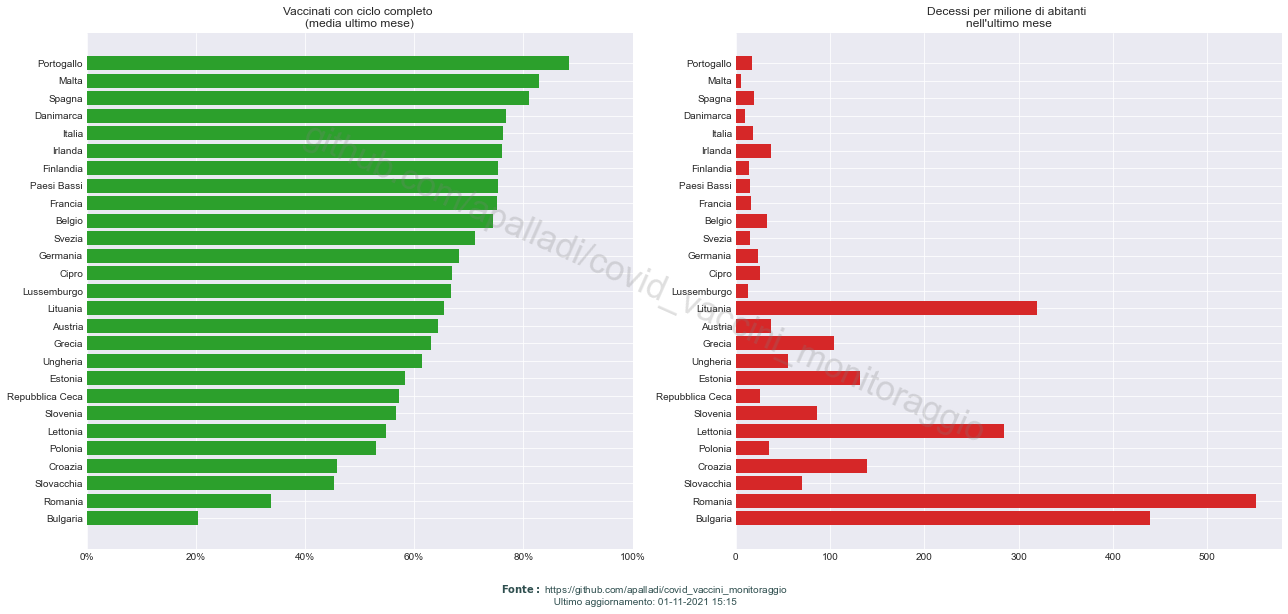

In [16]:
plt.style.use('seaborn-dark')

fig = plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.barh(paesi_label, vacc_res, color='C2')
plt.title('Vaccinati con ciclo completo \n(media ultimo mese)')
plt.grid()
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 20), ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.subplot(1, 2, 2)
plt.barh(paesi_label, dec_res, color='C3')
plt.title('Decessi per milione di abitanti \nnell\'ultimo mese')
plt.grid()
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())
plt.tight_layout()
plt.savefig('../risultati/correlazione_vaccini_decessi.png', dpi=300, bbox_inches="tight")
plt.show()

In [17]:
corr_coeff = np.corrcoef(vacc_res, dec_res)[0, 1]
print('Il coefficiente di correlazione tra frazione di vaccinati e decessi nell\'ultimo mese è', 
      round(corr_coeff, 2))

Il coefficiente di correlazione tra frazione di vaccinati e decessi nell'ultimo mese è -0.75


### Variazione della correlazione in funzione del tempo

In [18]:
def corr_window(tw):

    dec_res=[]
    vacc_res=[]

    for i, p in enumerate(paesi):
        vacc_res.append(get_vaccine_data(p, time_window = tw, fully=True))
        dec_res.append(get_deaths(p, time_window = tw)/abitanti[i])
        
    corr_tw = np.corrcoef(vacc_res, dec_res)[0, 1]

    return corr_tw

In [19]:
tw_grid = np.arange(7, 121, 5)

corr_grid = [np.abs(corr_window(tw)) for tw in tw_grid]

C:\Users\Claudio\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Claudio\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


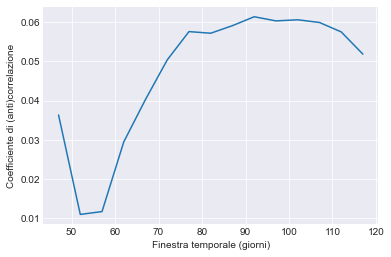

In [20]:
plt.plot(tw_grid, corr_grid)
plt.xlabel('Finestra temporale (giorni)')
plt.ylabel('Coefficiente di (anti)correlazione')
plt.grid()
plt.show()

### Decessi vs vaccini

watermark fontsize: 23, angle:-45.0


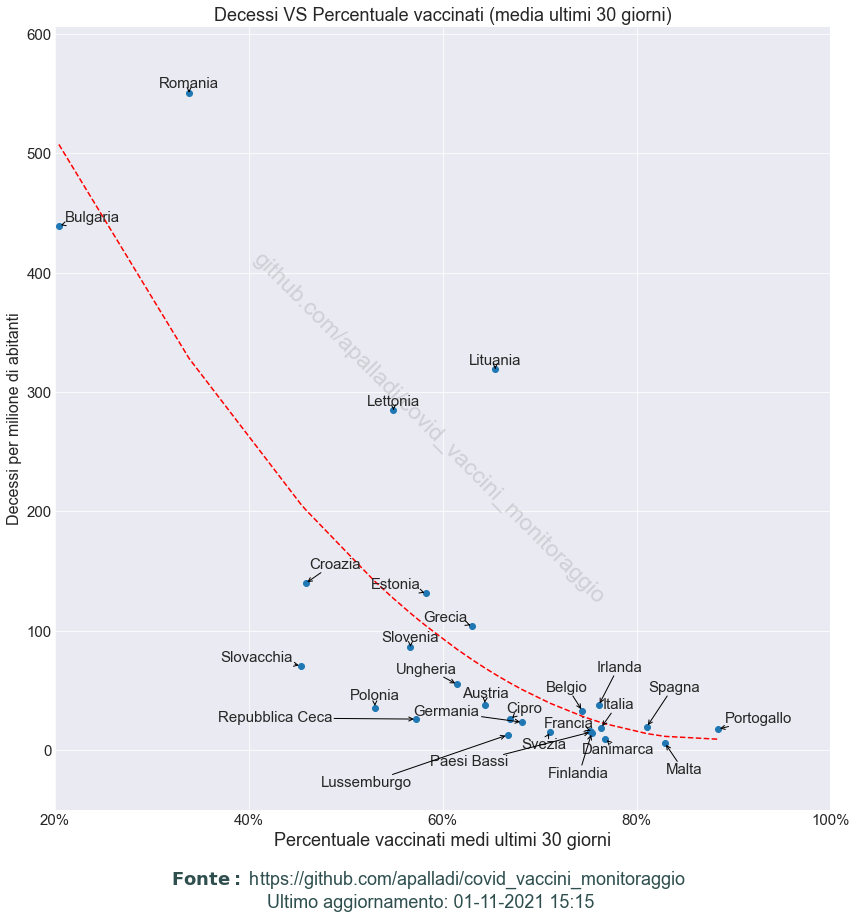

In [21]:
plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(vacc_res, dec_res)
corr_coeff = round(np.corrcoef(vacc_res, dec_res)[0, 1], 2)
plt.title(f'Decessi VS Percentuale vaccinati (media ultimi {tw} giorni)', fontsize=18)
plt.grid()
plt.xlabel(f'Percentuale vaccinati medi ultimi {tw} giorni', fontsize=18)
plt.xlim(20, 100)
plt.ylabel('Decessi per milione di abitanti', fontsize=16)
plt.ylim(-50, max(dec_res)*1.1)
plt.xticks(np.arange(20, 101, 20), ['20%', '40%', '60%', '80%', '100%'], fontsize=15)
plt.yticks(fontsize=15)

# Add annotation
texts = []
for i, el in enumerate(paesi_label):
    texts.append(ax.text(vacc_res[i], dec_res[i], el, fontsize=15))
adjust_text(texts, autoalign={'y'}, precision=0.01, arrowprops=dict(arrowstyle='->', color='black'))

# Plot line that fits
z = np.polyfit(vacc_res, dec_res, 2)
p = np.poly1d(z)
plt.plot(vacc_res, p(sorted(vacc_res)),"r--")

ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())
plt.tight_layout()
plt.savefig('../risultati/correlazione_decessi_vaccini.png', dpi=300, bbox_inches="tight")
plt.show()

In [22]:
corr_coeff = round(np.corrcoef((vacc_res, dec_res))[0, 1], 2)
corr_coeff

-0.75

### Vaccini vs GDP

watermark fontsize: 23, angle:-45.0


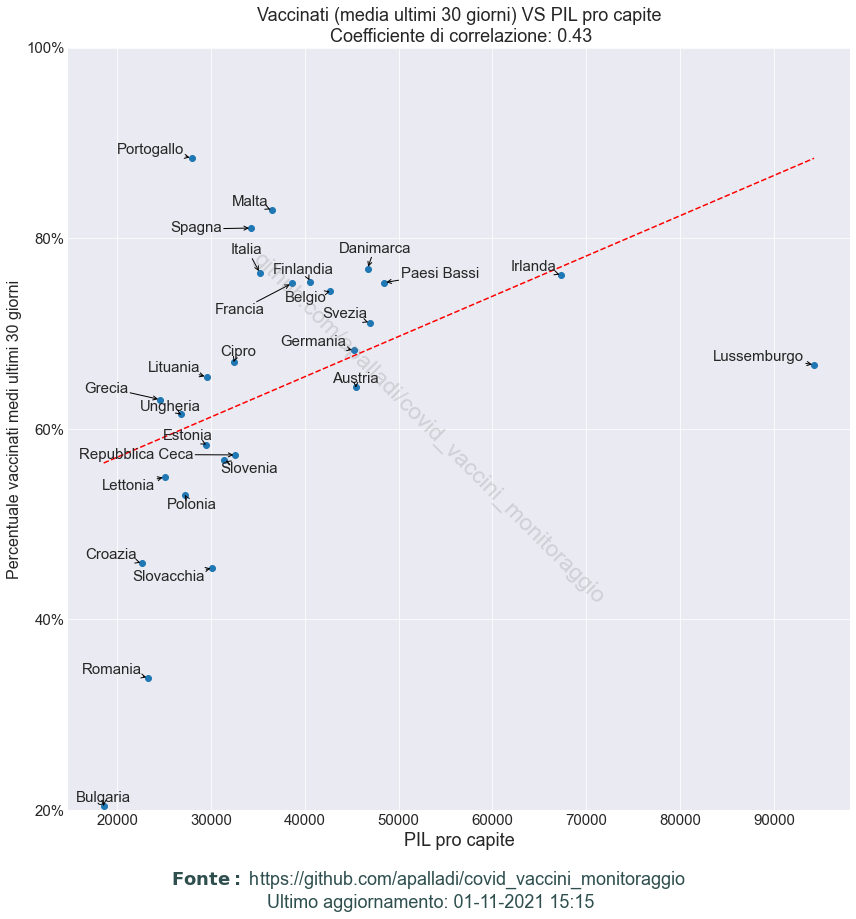

In [23]:
plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(gdp, vacc_res)
corr_coeff = round(np.corrcoef(sorted(gdp), [x for _, x in sorted(zip(gdp, vacc_res))])[0, 1], 2)
plt.title(f'Vaccinati (media ultimi {tw} giorni) VS PIL pro capite\n Coefficiente di correlazione: {corr_coeff}', fontsize=18)
plt.grid()
plt.xlabel('PIL pro capite', fontsize=18)
plt.ylabel(f'Percentuale vaccinati medi ultimi {tw} giorni', fontsize=16)
plt.ylim(20)
plt.xticks(fontsize=15)
plt.yticks(np.arange(20, 101, 20), ['20%', '40%', '60%', '80%', '100%'], fontsize=15)

# Add annotation
texts = []
for i, el in enumerate(paesi_label):
    texts.append(ax.text(gdp[i], vacc_res[i], el, fontsize=15))
adjust_text(texts, autoalign={'y'}, precision=0.01, arrowprops=dict(arrowstyle='->', color='black'))

# Plot line that fits
z = np.polyfit(sorted(gdp), [x for _, x in sorted(zip(gdp, vacc_res))], 1)
p = np.poly1d(z)
plt.plot(sorted(gdp), p(sorted(gdp)),"r--")

ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())
plt.tight_layout()
plt.savefig('../risultati/correlazione_vaccini_gdp_no_outliers.png', dpi=300, bbox_inches="tight")
plt.show()

In [24]:
# Exclude Luxembourg and Ireland (outliers)
lux_index = paesi.index("Luxembourg")
paesi.pop(lux_index)
paesi_label.pop(lux_index)
vacc_res.pop(lux_index)
gdp.pop(lux_index)

ire_index = paesi.index("Ireland")
paesi.pop(ire_index)
paesi_label.pop(ire_index)
vacc_res.pop(ire_index)
gdp.pop(ire_index)

67335.293

watermark fontsize: 23, angle:-45.0


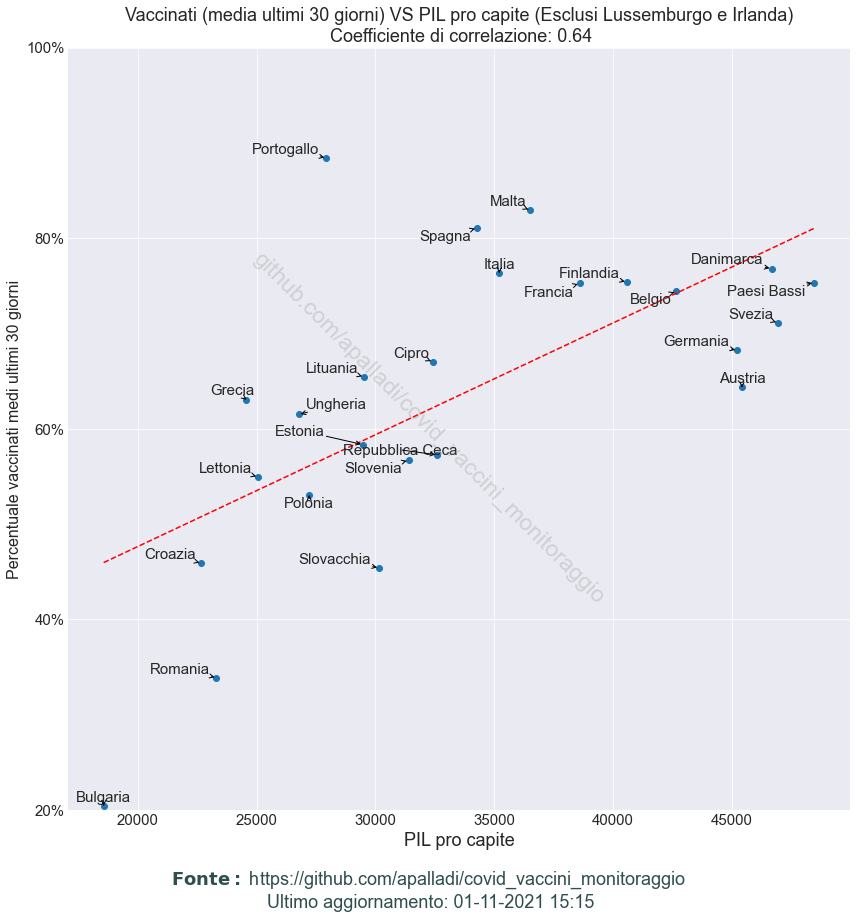

In [25]:
plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(gdp, vacc_res)
corr_coeff = round(np.corrcoef(sorted(gdp), [x for _, x in sorted(zip(gdp, vacc_res))])[0, 1], 2)
plt.title(f'Vaccinati (media ultimi {tw} giorni) VS PIL pro capite (Esclusi Lussemburgo e Irlanda)\n Coefficiente di correlazione: {corr_coeff}', fontsize=18)
plt.grid()
plt.xlabel('PIL pro capite', fontsize=18)
plt.ylabel(f'Percentuale vaccinati medi ultimi {tw} giorni', fontsize=16)
plt.ylim(20)
plt.xticks(fontsize=15)
plt.yticks(np.arange(20, 101, 20), ['20%', '40%', '60%', '80%', '100%'], fontsize=15)

# Add annotation
texts = []
for i, el in enumerate(paesi_label):
    texts.append(ax.text(gdp[i], vacc_res[i], el, fontsize=15))
adjust_text(texts, autoalign={'y'}, precision=0.01, arrowprops=dict(arrowstyle='->', color='black'))

# Plot line that fits
z = np.polyfit(sorted(gdp), [x for _, x in sorted(zip(gdp, vacc_res))], 1)
p = np.poly1d(z)
plt.plot(sorted(gdp), p(sorted(gdp)),"r--")

ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())
plt.tight_layout()
plt.savefig('../risultati/correlazione_vaccini_gdp_no_outliers.png', dpi=300, bbox_inches="tight")
plt.show()

### Modello con regressione lineare

In [30]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [42]:
X.columns.tolist()

['Perc_vacc_last_30_days',
 'GDP_per_capita',
 'population_density',
 'aged_70_older',
 'extreme_poverty',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'hospital_beds_per_thousand',
 'human_development_index']

In [43]:
# Define data
X = df_europe_small.drop(['Deaths_last_30_days'], 
#                           'cardiovasc_death_rate', 
#                           'diabetes_prevalence', 
#                           'hospital_beds_per_thousand', 
#                           'human_development_index', 
#                           'aged_70_older'], 
                         axis=1)
# Fill NaN values with average of column
X.fillna(X.mean(), inplace=True)
# Scale data
scaler = StandardScaler()
X[X.columns.tolist()] = scaler.fit_transform(X[X.columns.tolist()])

Y = df_europe_small['Deaths_last_30_days']

In [45]:
#DEBUGONLY
X

,Perc_vacc_last_30_days,GDP_per_capita,population_density,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,human_development_index
Country,,,,,,,,,
Bulgaria,-2.914323,-1.222393,-0.418071,0.350311,5.303863e-01,2.481601,-0.197836,1.460760,-2.110832
Romania,-2.021667,-0.910558,-0.344579,-0.453144,4.639593e+00,1.900780,1.948628,1.128330,-1.836830
Slovakia,-1.255298,-0.461376,-0.241433,-1.734602,-2.523197e-01,1.003825,0.610501,0.493150,-1.014823
Croatia,-1.222729,-0.952797,-0.386574,0.238437,-2.523197e-01,0.634408,-0.317995,0.326934,-1.288825
Poland,-0.747487,-0.654306,-0.201280,-1.210831,-2.172446e-16,0.348537,-0.143219,0.968051,-0.466819
Latvia,-0.619870,-0.795626,-0.543208,0.792719,-2.523197e-01,1.675001,-0.689393,0.344743,-0.740821
Slovenia,-0.503552,-0.379596,-0.280150,0.177415,-2.172446e-16,-0.449524,0.588654,-0.290437,0.629190
Czechia,-0.466330,-0.300482,-0.152839,-0.509080,-2.172446e-16,0.350159,0.353799,0.973987,0.081186
Estonia,-0.394545,-0.505619,-0.543872,0.462184,-4.479962e-01,0.653755,-1.175488,-0.177648,-0.192816


In [46]:
# Create model
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 94.25000000000003
Coefficients: 
 [ -0.61218959  18.09211268   2.99495223  17.05187249  60.00673097
 114.35554293 -11.61415779 -15.05010694   0.33973094]
                             OLS Regression Results                            
Dep. Variable:     Deaths_last_30_days   R-squared:                       0.891
Model:                             OLS   Adj. R-squared:                  0.833
Method:                  Least Squares   F-statistic:                     15.44
Date:                 Mon, 01 Nov 2021   Prob (F-statistic):           1.59e-06
Time:                         15:26:33   Log-Likelihood:                -141.38
No. Observations:                   27   AIC:                             302.8
Df Residuals:                       17   BIC:                             315.7
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                                 